3D model options test script
============================
This test script is to test implemented features with tertiary structures.

You can also use it to view the different options and how they look.
The function calls are likely to stay the same, but the default plots
may look a little different in the future.

Currently broken
----------------
* nothing that I'm aware of

Notebook set-up
---------------

ipykernel_launcher:20: RuntimeWarning: invalid value encountered in true_divide
ipykernel_launcher:22: RuntimeWarning: invalid value encountered in greater
ipykernel_launcher:51: RuntimeWarning: Mean of empty slice
0.006863450055682967
0.006863450055682967
0.03947908344706033
0.03947908344706033
-0.20160182410835292
-0.20160182410835292
-9.843279246223881
-9.843279246223881
ipykernel_launcher:91: RuntimeWarning: Mean of empty slice
ipykernel_launcher:95: RuntimeWarning: invalid value encountered in less
ipykernel_launcher:96: RuntimeWarning: invalid value encountered in greater


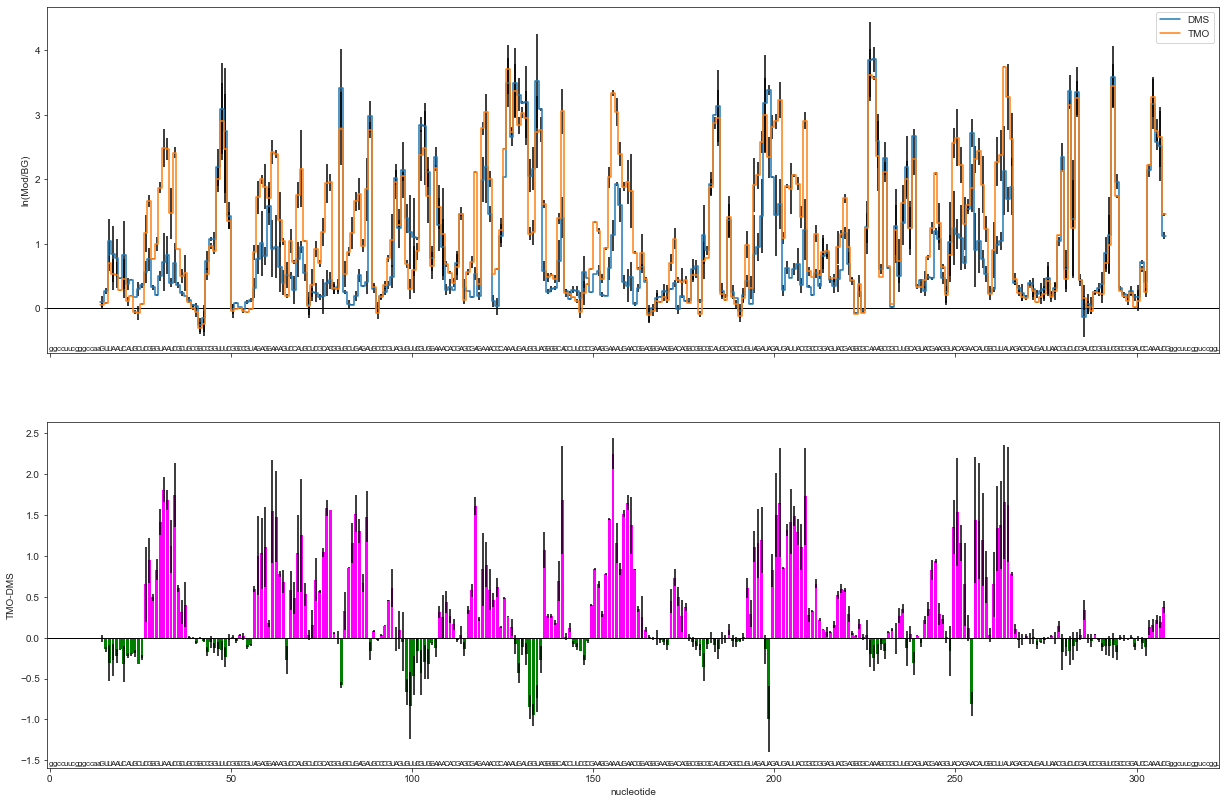

In [7]:
import matplotlib as mp
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_table
import seaborn as sb
from scipy.optimize import minimize_scalar
sb.set_style('ticks')


def load_seq(filename):
    df=read_table(filename)
    seq=df.Sequence.values.tolist()
    return seq


def load_profile(filename):
    df1=read_table(filename)
    plus=df1.Modified_rate.values.copy()
    minus=df1.Untreated_rate.values.copy()
    profile=plus/minus
    profile=np.log(profile)
    profile[minus>0.05]=np.nan
    return profile

def calcscalefactor(profile,target_profile):
    def f(offset):
        return np.nanmedian(np.abs(profile + offset - target_profile))
    result = minimize_scalar(f, bounds=[-20, 20])
    offset = result.x
    print(offset)
    return offset

def rescale(profile,target_profile):
    offset=calcscalefactor(profile,target_profile)
    print(offset)
    return profile+offset

def loadreplicates(*filenames):
    profile1 = load_profile(filenames[0])
    seq = load_seq(filenames[0])
    primermask = np.array([True if c.islower() else False for c in seq])
    profile1[primermask]=np.nan

    profiles = [profile1]
    for filename in filenames[1:]:
        profile = load_profile(filename)
        profile[primermask]=np.nan
        profile = rescale(profile, profile1)
        profiles.append(profile)
    stacked=np.vstack(profiles)
    avgprofile=np.nanmean(stacked,axis=0)
    stderr=np.std(stacked,axis=0)
    return avgprofile, stderr, stacked, seq

def plotseq(sequence,ax=None):
    if ax is None:
        ax=plt.gca()
    x=list(range(1,len(sequence)+1))
    trans= ax.get_xaxis_transform()
    for i in range(len(sequence)):
        c = sequence[i]
        ax.text(x[i]-0.5,0.003,c,fontsize=8,transform=trans,va='bottom',ha='center',clip_on=True)


dmsfilenames = ['data/example1_rnasep_profile.txt', 'data/example3_rnasep_profile.txt']
dmsprofile, dms_stderr, dms_stacked, seq=loadreplicates(*dmsfilenames)

tmofilenames = ['data/example2_rnasep_profile.txt', 'data/example4_rnasep_profile.txt']
tmoprofile, tmo_stderr, tmo_stacked, seq=loadreplicates(*tmofilenames)
tmoprofile = rescale(tmoprofile,dmsprofile)

fig,axes=plt.subplots(2,1,figsize=(21,14),sharex=True)
ax=axes[0]
axes[1].set_xlabel('nucleotide')
x=np.array(list(range(1,len(dmsprofile)+1)))
ax.step(x,dmsprofile,label='DMS')
ax.step(x,tmoprofile,label='TMO')
ax.errorbar(x-0.5,dmsprofile,yerr=dms_stderr,fmt='none',color='black')
ax.errorbar(x-0.5,tmoprofile,yerr=tmo_stderr,fmt='none',color='black')
ax.legend(loc='upper right')
ax.axhline(0,color='black',lw=1,zorder=0)
ax.set_ylabel('ln(Mod/BG)')
plotseq(seq,ax=ax)

ax=axes[1]
dms_stacked=dms_stacked+10
rescale_dms=rescale(dms_stacked,tmo_stacked)
debugdiff=rescale_dms-dms_stacked
dms_stacked=rescale_dms
diff=tmo_stacked-dms_stacked
meandiff=np.nanmean(diff,axis=0)
std_err=np.std(diff,axis=0)
upper=meandiff.copy()
lower=meandiff.copy()
upper[upper<0]=np.nan
lower[lower>0]=np.nan
ax.bar(x-0.5,upper,color='magenta',lw=0)
ax.bar(x-0.5,lower,color='green',lw=0)
ax.axhline(0,color='black',lw=1)
ax.set_ylabel('TMO-DMS')
ax.errorbar(x-0.5,meandiff,yerr=std_err,fmt='none',color='black')
plotseq(seq,ax=ax)
# offset = -13
# ticklocs,ticklabels=plt.xticks()
# ticklabels=[str(int(loc+offset)) for loc in ticklocs]
# plt.xticks(ticklocs,ticklabels)


plt.show()